In [1]:
import pandas as pd
import random
from datetime import datetime, timedelta

# -----------------------------
# CONFIGURATION
# -----------------------------
NUM_OPERATION_RECORDS = 100000     # Increase to 500000 if needed
NUM_RISK_EVENTS = 20000

start_date = datetime(2024, 1, 1)
end_date = datetime(2025, 1, 1)

departments = [
    (101, "Operations"),
    (102, "Finance"),
    (103, "IT"),
    (104, "Risk"),
    (105, "Compliance")
]

# -----------------------------
# 1. DEPARTMENTS CSV
# -----------------------------
df_departments = pd.DataFrame(departments, columns=["dept_id", "dept_name"])
df_departments.to_csv("departments.csv", index=False)

# -----------------------------
# 2. OPERATIONS DATA CSV
# -----------------------------
operations_data = []

for i in range(1, NUM_OPERATION_RECORDS + 1):
    dept_id = random.choice(departments)[0]
    date = start_date + timedelta(days=random.randint(0, 365))

    transactions = random.randint(50, 500)
    errors = random.randint(0, int(transactions * 0.15))
    delay_minutes = random.randint(0, 60)

    operations_data.append([
        i, dept_id, date.strftime("%Y-%m-%d"),
        transactions, errors, delay_minutes
    ])

df_operations = pd.DataFrame(
    operations_data,
    columns=[
        "record_id", "dept_id", "date",
        "transactions", "errors", "delay_minutes"
    ]
)

df_operations.to_csv("operations_data.csv", index=False)

# -----------------------------
# 3. RISK EVENTS CSV
# -----------------------------
risk_types = ["Process Failure", "System Downtime", "Compliance Breach", "Fraud Alert"]
severity_levels = ["Low", "Medium", "High", "Critical"]

risk_events = []

for i in range(1, NUM_RISK_EVENTS + 1):
    dept_id = random.choice(departments)[0]
    date = start_date + timedelta(days=random.randint(0, 365))

    risk_events.append([
        i,
        dept_id,
        random.choice(risk_types),
        random.choice(severity_levels),
        date.strftime("%Y-%m-%d")
    ])

df_risk = pd.DataFrame(
    risk_events,
    columns=["event_id", "dept_id", "risk_type", "severity", "date"]
)

df_risk.to_csv("risk_events.csv", index=False)

print("✅ Large enterprise datasets generated successfully!")

✅ Large enterprise datasets generated successfully!


In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# -----------------------------
# 1. LOAD DATA
# -----------------------------
df_departments = pd.read_csv("departments.csv")
df_operations = pd.read_csv("operations_data.csv")
df_risk = pd.read_csv("risk_events.csv")

# -----------------------------
# 2. INITIAL CLEANING
# -----------------------------
# Remove duplicates
df_operations.drop_duplicates(inplace=True)
df_risk.drop_duplicates(inplace=True)

# Handle missing values
df_operations.dropna(inplace=True)
df_risk["severity"] = df_risk["severity"].fillna("Unknown")

# -----------------------------
# 3. DATA TYPE CONVERSION
# -----------------------------
df_operations["date"] = pd.to_datetime(df_operations["date"])
df_risk["date"] = pd.to_datetime(df_risk["date"])

# -----------------------------
# 4. DATA VALIDATION
# -----------------------------
df_operations = df_operations[
    (df_operations["errors"] <= df_operations["transactions"]) &
    (df_operations["delay_minutes"] >= 0)
]

# -----------------------------
# 5. FEATURE ENGINEERING
# -----------------------------
# Error rate
df_operations["error_rate"] = (
    df_operations["errors"] / df_operations["transactions"]
)

# Month extraction
df_operations["month"] = df_operations["date"].dt.to_period("M")

# Encode severity
severity_map = {
    "Low": 1,
    "Medium": 2,
    "High": 3,
    "Critical": 4
}
df_risk["severity_score"] = df_risk["severity"].map(severity_map)

# High-risk flag
df_risk["high_risk_flag"] = df_risk["severity"].isin(
    ["High", "Critical"]
).astype(int)

# -----------------------------
# 6. MERGE DATASETS
# -----------------------------
df_operations = df_operations.merge(
    df_departments, on="dept_id", how="left"
)

df_final = df_operations.merge(
    df_risk,
    on=["dept_id", "date"],
    how="left"
)

# -----------------------------
# 7. OUTLIER HANDLING (IQR)
# -----------------------------
Q1 = df_final["delay_minutes"].quantile(0.25)
Q3 = df_final["delay_minutes"].quantile(0.75)
IQR = Q3 - Q1

df_final = df_final[
    (df_final["delay_minutes"] >= Q1 - 1.5 * IQR) &
    (df_final["delay_minutes"] <= Q3 + 1.5 * IQR)
]

# -----------------------------
# 8. SCALING (FOR ML)
# -----------------------------
scaler = StandardScaler()
df_final[["transactions", "errors", "delay_minutes"]] = scaler.fit_transform(
    df_final[["transactions", "errors", "delay_minutes"]]
)

# -----------------------------
# 9. SAVE PREPROCESSED DATA
# -----------------------------
df_final.to_csv("preprocessed_enterprise_data.csv", index=False)

print("✅ Data preprocessing completed successfully!")

✅ Data preprocessing completed successfully!


   record_id  dept_id       date  transactions    errors  delay_minutes  \
0          1      104 2024-02-06      0.647339  0.529688       -0.84978   
1          1      104 2024-02-06      0.647339  0.529688       -0.84978   
2          1      104 2024-02-06      0.647339  0.529688       -0.84978   
3          1      104 2024-02-06      0.647339  0.529688       -0.84978   
4          1      104 2024-02-06      0.647339  0.529688       -0.84978   

   error_rate    month dept_name  event_id          risk_type  severity  \
0     0.08078  2024-02      Risk      3226    Process Failure    Medium   
1     0.08078  2024-02      Risk      3360    Process Failure       Low   
2     0.08078  2024-02      Risk      6987    System Downtime  Critical   
3     0.08078  2024-02      Risk      9860    Process Failure    Medium   
4     0.08078  2024-02      Risk     10415  Compliance Breach       Low   

   severity_score  high_risk_flag  
0               2               0  
1               1         

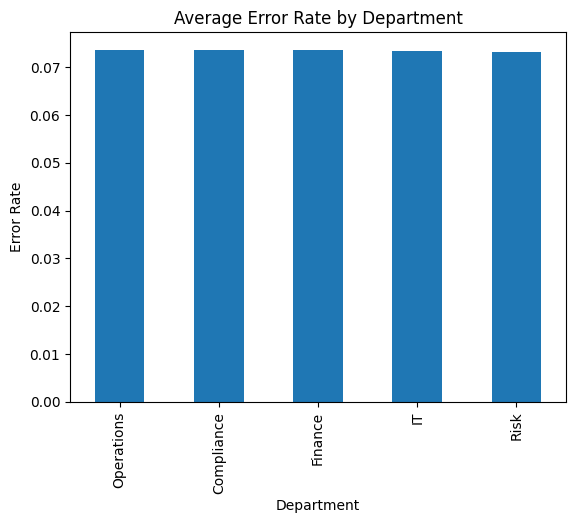

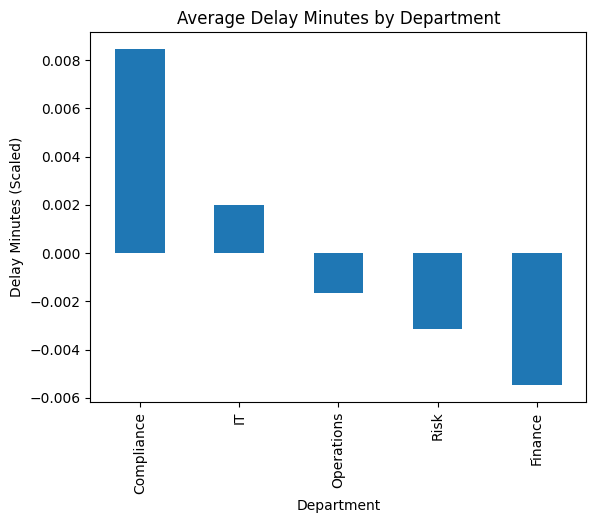

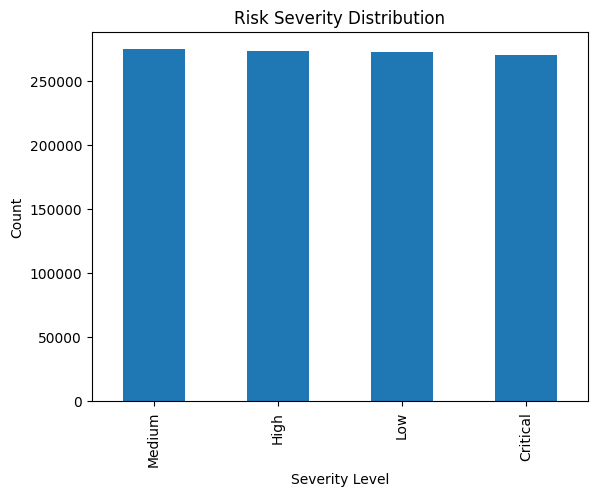

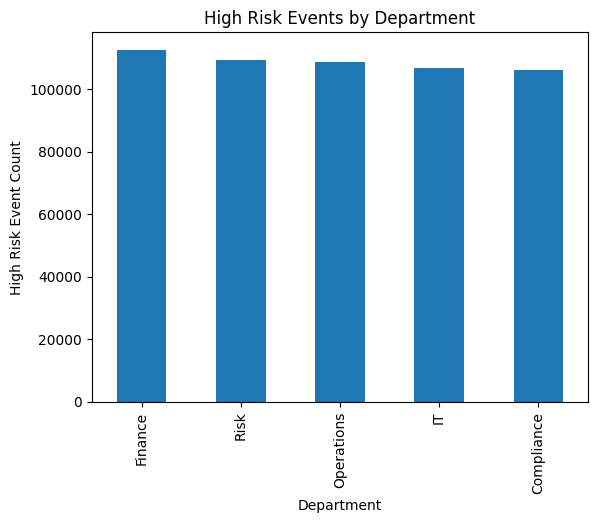

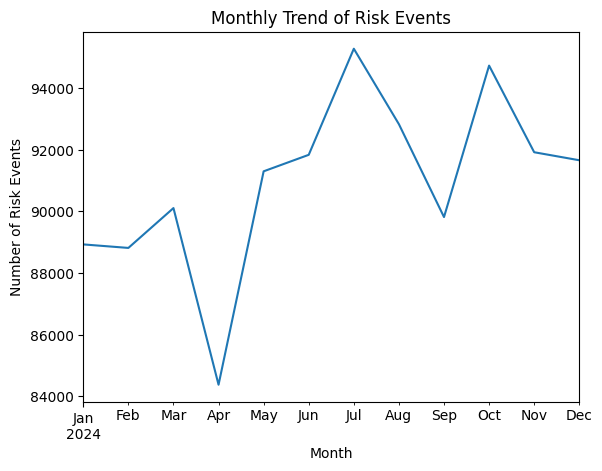

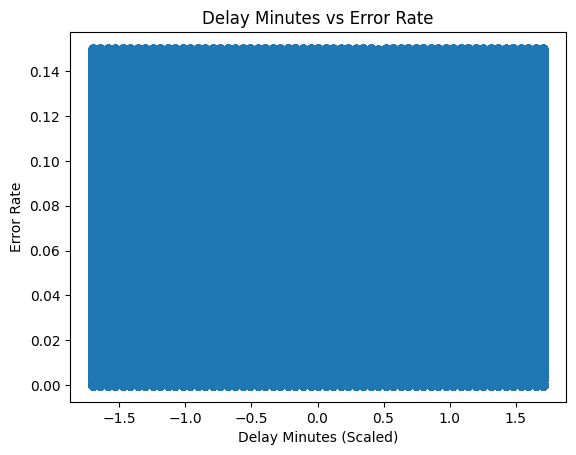

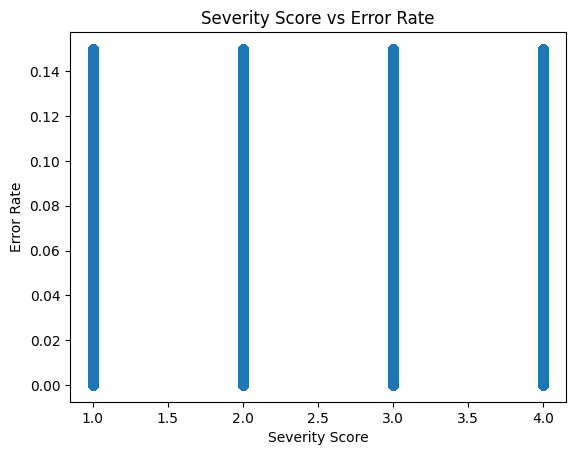

✅ Exploratory Data Analysis completed successfully!


In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# --------------------------------------------------
# 1. LOAD DATA
# --------------------------------------------------
df = pd.read_csv("preprocessed_enterprise_data.csv")

# Convert date columns to datetime
df["date"] = pd.to_datetime(df["date"])

# Recreate month column (safe if already present)
df["month"] = df["date"].dt.to_period("M")

# Preview dataset structure
print(df.head())
print(df.info())

# --------------------------------------------------
# 2. MISSING VALUE HANDLING
# --------------------------------------------------
# Risk-related columns can be null due to LEFT JOIN
df["severity"] = df["severity"].fillna("No Risk")
df["severity_score"] = df["severity_score"].fillna(0)
df["high_risk_flag"] = df["high_risk_flag"].fillna(0)

# --------------------------------------------------
# 3. DEPARTMENT-WISE AVERAGE ERROR RATE
# --------------------------------------------------
dept_error_rate = (
    df.groupby("dept_name")["error_rate"]
    .mean()
    .sort_values(ascending=False)
)

plt.figure()
dept_error_rate.plot(kind="bar")
plt.title("Average Error Rate by Department")
plt.xlabel("Department")
plt.ylabel("Error Rate")
plt.show()

# --------------------------------------------------
# 4. DEPARTMENT-WISE AVERAGE DELAY
# --------------------------------------------------
dept_delay = (
    df.groupby("dept_name")["delay_minutes"]
    .mean()
    .sort_values(ascending=False)
)

plt.figure()
dept_delay.plot(kind="bar")
plt.title("Average Delay Minutes by Department")
plt.xlabel("Department")
plt.ylabel("Delay Minutes (Scaled)")
plt.show()

# --------------------------------------------------
# 5. RISK SEVERITY DISTRIBUTION
# --------------------------------------------------
severity_distribution = df["severity"].value_counts()

plt.figure()
severity_distribution.plot(kind="bar")
plt.title("Risk Severity Distribution")
plt.xlabel("Severity Level")
plt.ylabel("Count")
plt.show()

# --------------------------------------------------
# 6. HIGH-RISK EVENTS BY DEPARTMENT
# --------------------------------------------------
high_risk_by_dept = (
    df[df["high_risk_flag"] == 1]
    .groupby("dept_name")
    .size()
    .sort_values(ascending=False)
)

plt.figure()
high_risk_by_dept.plot(kind="bar")
plt.title("High Risk Events by Department")
plt.xlabel("Department")
plt.ylabel("High Risk Event Count")
plt.show()

# --------------------------------------------------
# 7. MONTHLY TREND OF RISK EVENTS
# --------------------------------------------------
monthly_risk_events = (
    df[df["event_id"].notna()]
    .groupby("month")
    .size()
)

plt.figure()
monthly_risk_events.plot()
plt.title("Monthly Trend of Risk Events")
plt.xlabel("Month")
plt.ylabel("Number of Risk Events")
plt.show()

# --------------------------------------------------
# 8. DELAY MINUTES VS ERROR RATE
# --------------------------------------------------
plt.figure()
plt.scatter(df["delay_minutes"], df["error_rate"])
plt.title("Delay Minutes vs Error Rate")
plt.xlabel("Delay Minutes (Scaled)")
plt.ylabel("Error Rate")
plt.show()

# --------------------------------------------------
# 9. SEVERITY SCORE VS ERROR RATE
# --------------------------------------------------
plt.figure()
plt.scatter(df["severity_score"], df["error_rate"])
plt.title("Severity Score vs Error Rate")
plt.xlabel("Severity Score")
plt.ylabel("Error Rate")
plt.show()

print("✅ Exploratory Data Analysis completed successfully!")

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --------------------------------------------------
# 1. LOAD DATA
# --------------------------------------------------
df = pd.read_csv("preprocessed_enterprise_data.csv")

# Convert date column
df["date"] = pd.to_datetime(df["date"])

# Handle missing risk values (from LEFT JOIN)
df["severity_score"] = df["severity_score"].fillna(0)
df["high_risk_flag"] = df["high_risk_flag"].fillna(0)

# --------------------------------------------------
# 2. FEATURE SELECTION
# --------------------------------------------------
# Input features for prediction
features = [
    "transactions",
    "errors",
    "delay_minutes",
    "error_rate",
    "severity_score"
]

X = df[features]
y = df["high_risk_flag"]

# --------------------------------------------------
# 3. TRAIN-TEST SPLIT
# --------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# --------------------------------------------------
# 4. MODEL TRAINING
# --------------------------------------------------
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# --------------------------------------------------
# 5. MODEL PREDICTION
# --------------------------------------------------
y_pred = model.predict(X_test)

# --------------------------------------------------
# 6. MODEL EVALUATION
# --------------------------------------------------
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# --------------------------------------------------
# 7. FEATURE IMPORTANCE (CONSULTING GOLD)
# --------------------------------------------------
importance = pd.Series(
    model.coef_[0],
    index=features
).sort_values(ascending=False)

print("\nFeature Importance:\n")
print(importance)

print("\n✅ High Risk Event Prediction Model Trained Successfully!")

Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    164306
           1       1.00      1.00      1.00    163171

    accuracy                           1.00    327477
   macro avg       1.00      1.00      1.00    327477
weighted avg       1.00      1.00      1.00    327477


Confusion Matrix:
 [[164306      0]
 [     0 163171]]

Feature Importance:

severity_score    14.956075
errors             0.208001
delay_minutes      0.047558
transactions      -0.009146
error_rate        -2.657460
dtype: float64

✅ High Risk Event Prediction Model Trained Successfully!


Sample KPI metrics:
  dept_name  transactions    errors  delay_minutes  error_rate  \
0      Risk      0.647339  0.529688       -0.84978    0.818254   
1      Risk      0.647339  0.529688       -0.84978    0.818254   
2      Risk      0.647339  0.529688       -0.84978    0.818254   
3      Risk      0.647339  0.529688       -0.84978    0.818254   
4      Risk      0.647339  0.529688       -0.84978    0.818254   

   efficiency_score  exceptions  
0          4.309261    0.529688  
1          4.309261    0.529688  
2          4.309261    0.529688  
3          4.309261    0.529688  
4          4.309261    0.529688  

Department-wise Risk Metrics:
    dept_name  total_events  high_risk_events  avg_severity_score  \
0  Compliance        217917            154836            2.477154   
1     Finance        224672            160097            2.508328   
2          IT        215043            152885            2.482717   
3  Operations        217396            154202            2.502824   
4  

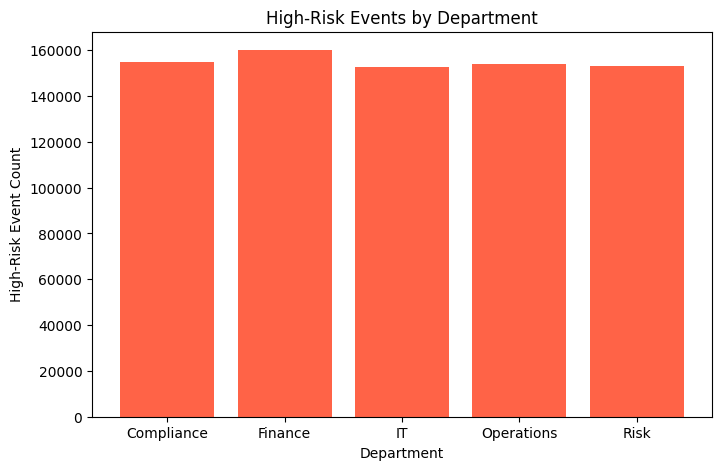

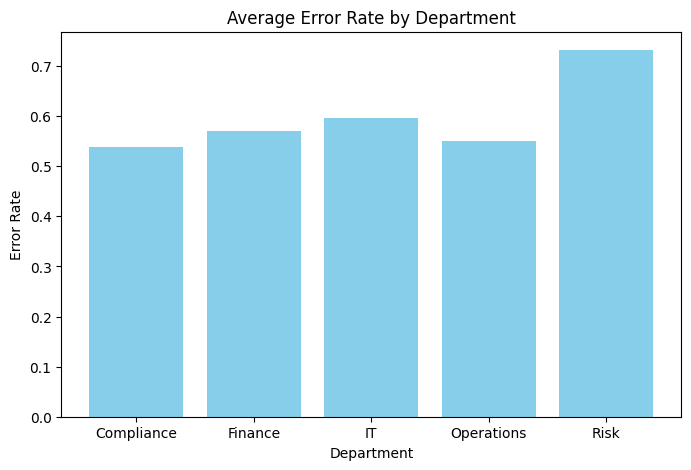

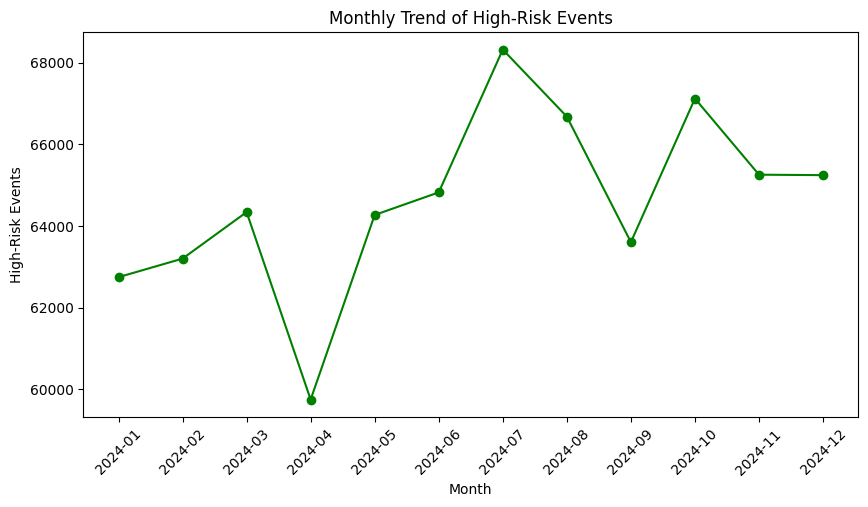

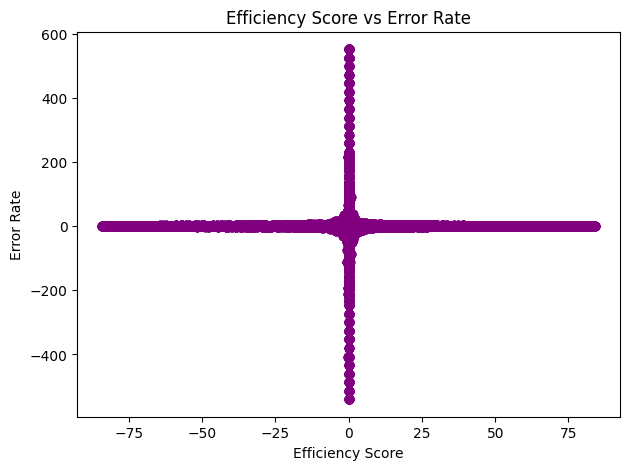

✅ Analytics & Insights Completed Successfully!


In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# --------------------------------------------------
# 1. LOAD DATA
# --------------------------------------------------
df = pd.read_csv("preprocessed_enterprise_data.csv")
df["date"] = pd.to_datetime(df["date"])
df["month"] = df["date"].dt.to_period("M")  # for monthly trend analysis

# --------------------------------------------------
# 2. OPERATIONAL KPIs
# --------------------------------------------------
# KPI 1: Error Rate
df["error_rate"] = df["errors"] / df["transactions"]

# KPI 2: Efficiency Score (Higher is better)
df["efficiency_score"] = df["transactions"] / (df["delay_minutes"] + 1)

# KPI 3: Exceptions = Number of errors per record
df["exceptions"] = df["errors"]

# Preview
print("Sample KPI metrics:")
print(df[["dept_name", "transactions", "errors", "delay_minutes", "error_rate", "efficiency_score", "exceptions"]].head())

# --------------------------------------------------
# 3. RISK METRICS
# --------------------------------------------------
# Threshold-based High Risk Flag (custom business logic)
# Example: severity_score > 70 OR error_rate > 0.05
df["high_risk_flag"] = df.apply(
    lambda row: 1 if (row["severity_score"] > 70 or row["error_rate"] > 0.05) else 0,
    axis=1
)

# Aggregated risk metrics per department
risk_metrics = df.groupby("dept_name").agg(
    total_events=("event_id", "count"),
    high_risk_events=("high_risk_flag", "sum"),
    avg_severity_score=("severity_score", "mean"),
    avg_error_rate=("error_rate", "mean")
).reset_index()

print("\nDepartment-wise Risk Metrics:")
print(risk_metrics)

# --------------------------------------------------
# 4. HISTORICAL TREND ANALYSIS
# --------------------------------------------------
# Trend of errors and high-risk events over months
monthly_trends = df.groupby("month").agg(
    total_transactions=("transactions", "sum"),
    total_errors=("errors", "sum"),
    high_risk_events=("high_risk_flag", "sum")
).reset_index()

print("\nMonthly Trend Metrics:")
print(monthly_trends.head())

# --------------------------------------------------
# 5. VISUALIZATION (Consulting-Grade)
# --------------------------------------------------

# A. High-Risk Events by Department
plt.figure(figsize=(8,5))
plt.bar(risk_metrics["dept_name"], risk_metrics["high_risk_events"], color="tomato")
plt.title("High-Risk Events by Department")
plt.xlabel("Department")
plt.ylabel("High-Risk Event Count")
plt.show()

# B. Average Error Rate by Department
plt.figure(figsize=(8,5))
plt.bar(risk_metrics["dept_name"], risk_metrics["avg_error_rate"], color="skyblue")
plt.title("Average Error Rate by Department")
plt.xlabel("Department")
plt.ylabel("Error Rate")
plt.show()

# C. Monthly Trend of High-Risk Events
plt.figure(figsize=(10,5))
plt.plot(monthly_trends["month"].astype(str), monthly_trends["high_risk_events"], marker='o', color='green')
plt.title("Monthly Trend of High-Risk Events")
plt.xlabel("Month")
plt.ylabel("High-Risk Events")
plt.xticks(rotation=45)
plt.show()

# D. Efficiency vs Error Rate Scatter (Operational Insight)
plt.figure(figsize=(7,5))
plt.scatter(df["efficiency_score"], df["error_rate"], alpha=0.5, color="purple")
plt.title("Efficiency Score vs Error Rate")
plt.xlabel("Efficiency Score")
plt.ylabel("Error Rate")
plt.show()

print("✅ Analytics & Insights Completed Successfully!")

In [17]:
import pandas as pd
from sqlalchemy import create_engine

# -----------------------------
# 1️⃣ Load CSV
# -----------------------------
csv_file = "preprocessed_enterprise_data.csv"  # path to your CSV
df = pd.read_csv(csv_file)
print("✅ CSV loaded. Total rows:", len(df))

# -----------------------------
# 2️⃣ MySQL connection (no password)
# -----------------------------
db_user = "pyuser"
db_password = "mypassword"   # now use a password
db_host = "localhost"
db_name = "enterprise_project"

engine = create_engine(f"mysql+pymysql://{db_user}:{db_password}@{db_host}/{db_name}")

# -----------------------------
# 3️⃣ Upload CSV to MySQL in chunks
# -----------------------------
chunksize = 50000  # safe for large datasets

df.to_sql(
    name="enterprise_data",
    con=engine,
    if_exists="replace",  # replace table if exists
    index=False,
    chunksize=chunksize
)
print("✅ CSV uploaded successfully!")

# -----------------------------
# 4️⃣ Verify Upload
# -----------------------------
with engine.connect() as conn:
    total_rows = conn.execute("SELECT COUNT(*) FROM enterprise_data").fetchone()[0]
    print("✅ Total rows in MySQL table:", total_rows)

✅ CSV loaded. Total rows: 1091590


RuntimeError: 'cryptography' package is required for sha256_password or caching_sha2_password auth methods

In [1]:
import pandas as pd
from sqlalchemy import create_engine

# -----------------------------
# 1️⃣ Load CSV
# -----------------------------
csv_file = "preprocessed_enterprise_data.csv"  # path to your CSV
df = pd.read_csv(csv_file)
print("✅ CSV loaded. Total rows:", len(df))

# -----------------------------
# 2️⃣ MySQL connection (no password)
# -----------------------------
db_user = "pyuser"
db_password = "mypassword"   # now use a password
db_host = "localhost"
db_name = "enterprise_project"

engine = create_engine(f"mysql+pymysql://{db_user}:{db_password}@{db_host}/{db_name}")

# -----------------------------
# 3️⃣ Upload CSV to MySQL in chunks
# -----------------------------
chunksize = 50000  # safe for large datasets

df.to_sql(
    name="enterprise_data",
    con=engine,
    if_exists="replace",  # replace table if exists
    index=False,
    chunksize=chunksize
)
print("✅ CSV uploaded successfully!")

# -----------------------------
# 4️⃣ Verify Upload
# -----------------------------
with engine.connect() as conn:
    total_rows = conn.execute("SELECT COUNT(*) FROM enterprise_data").fetchone()[0]
    print("✅ Total rows in MySQL table:", total_rows)

✅ CSV loaded. Total rows: 1091590


OperationalError: (pymysql.err.OperationalError) (1044, "Access denied for user 'pyuser'@'localhost' to database 'enterprise_project'")
(Background on this error at: https://sqlalche.me/e/20/e3q8)

In [18]:
pip install cryptography

Note: you may need to restart the kernel to use updated packages.
